# Tiny ImageNet: View Predictions and Saliency

This notebook predicts the top-5 most likely labels for a random selection of images. The human labels, along with the top-5 model predictions, are displayed below each picture. Also, a "saliency map" is displayed next to each image. The saliency map highlights areas that were most important in making the top prediction. 

It is worth noting that a human labeler would have a difficult time correctly identifying many of these down-sampled images. The human labelers had the advantage of 4x higher resolution images to make their predictions (256x256 vs. 64x64 images). So, the model performance is quite impressive considering the low-resolution images.

The last cell may be re-run multiple times to explore a new selection of pictures.

Python Notebook by Patrick Coady: [Learning Artificial Intelligence](http://learningai.io/)

In [1]:
from train import *
import tensorflow as tf
import glob
import matplotlib.pyplot as plt
import random
import scipy.ndimage

%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)

In [2]:
class TrainConfig(object):
    """Training configuration"""
    dropout_keep_prob = 1.0
    model_name = 'vgg_16'  # choose model 
    model = staticmethod(globals()[model_name])
    config_name = 'no_hue'  # choose training run

In [3]:
def predict(imgs, config):
    """Load most recent checkpoint, make predictions, compute saliency maps"""
    g = tf.Graph()
    with g.as_default():
        imgs_ph = tf.placeholder(dtype=tf.uint8, shape=(None, 56, 56, 3))
        logits = config.model(imgs_ph, config)
        top_pred = tf.reduce_max(logits, axis=1)
        top_5 = tf.nn.top_k(logits, k=5, sorted=True)
        # can't calculate gradient to integer, get float32 version of image:
        float_img = g.get_tensor_by_name('Cast:0')
        # calc gradient of top predicted class to image:
        grads = tf.gradients(top_pred, float_img)
        saver = tf.train.Saver()
        with tf.Session() as sess:
            path = 'checkpoints/' + config.model_name + '/' + config.config_name
            saver.restore(sess, tf.train.latest_checkpoint(path))
            feed_dict = {imgs_ph: imgs}
            top_5_np, grads_np = sess.run([top_5, grads], feed_dict=feed_dict)
      
    return top_5_np, grads_np

In [4]:
# get label integer -> text description dictionary
label_dict, class_description = build_label_dicts()
for i in range(len(class_description)):
    class_description[i] = class_description[i].split(',')[0]

INFO:tensorflow:Restoring parameters from checkpoints/vgg_16/no_hue/model-44000


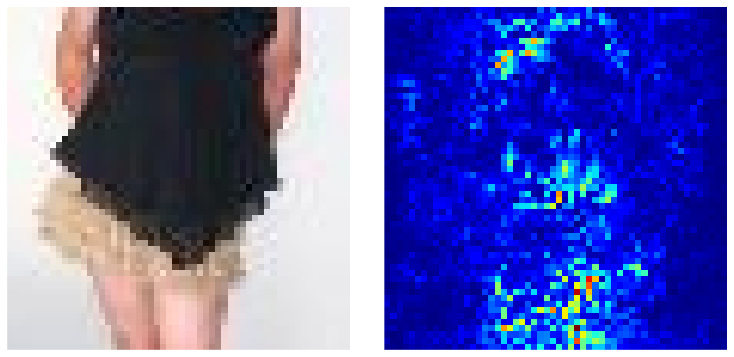

Actual label: miniskirt
Top 5 predictions:
['miniskirt', 'swimming trunks', 'apron', 'dumbbell', 'fur coat']




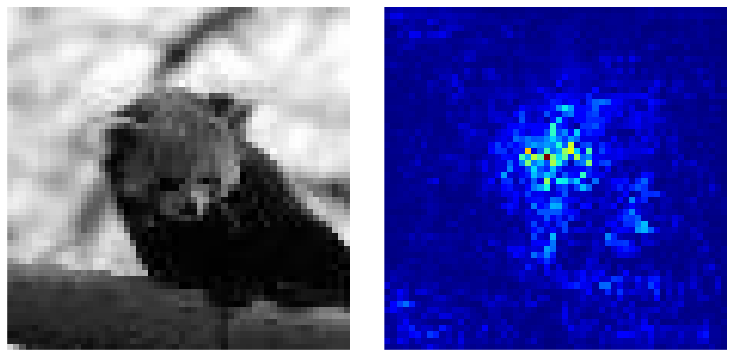

Actual label: lesser panda
Top 5 predictions:
['brown bear', 'baboon', 'hog', 'chimpanzee', 'Labrador retriever']




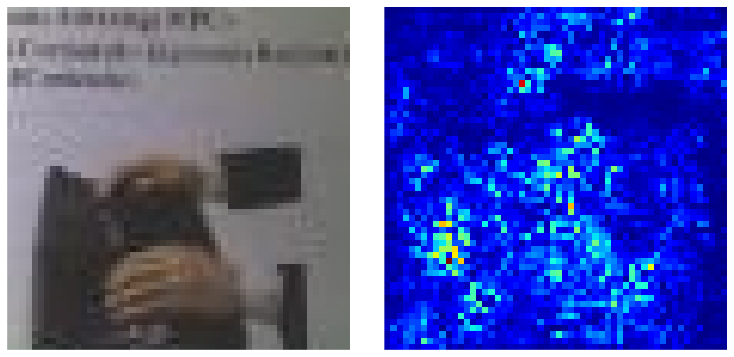

Actual label: computer keyboard
Top 5 predictions:
['plunger', 'dumbbell', 'bathtub', 'iPod', 'refrigerator']




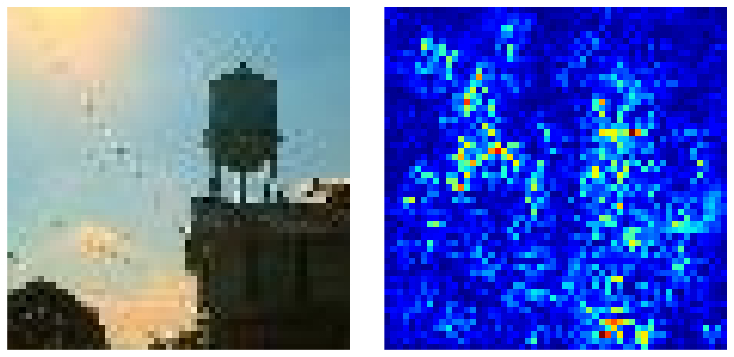

Actual label: water tower
Top 5 predictions:
['water tower', 'beacon', 'binoculars', 'birdhouse', 'military uniform']




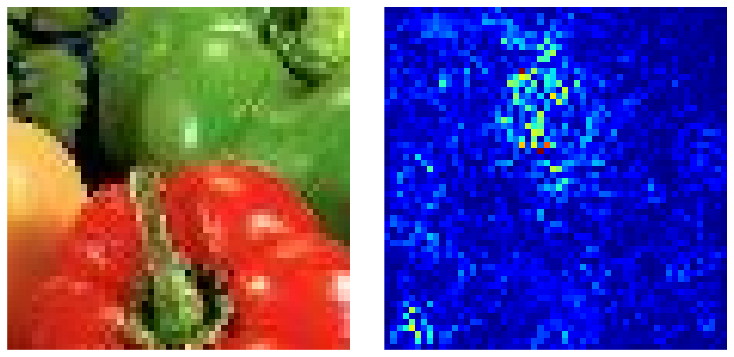

Actual label: bell pepper
Top 5 predictions:
['bell pepper', 'pomegranate', 'bee', 'banana', 'mantis']




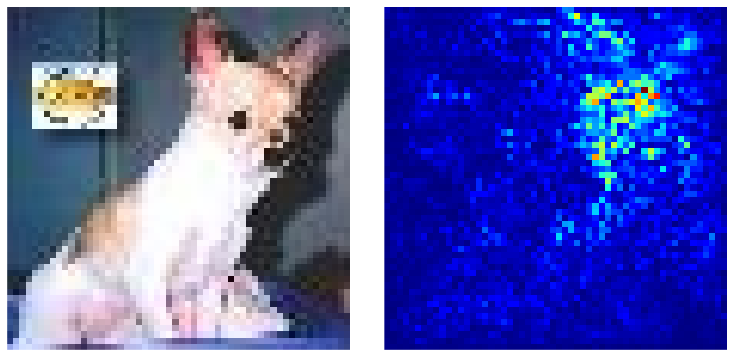

Actual label: Chihuahua
Top 5 predictions:
['Chihuahua', 'Persian cat', 'Egyptian cat', 'German shepherd', 'standard poodle']




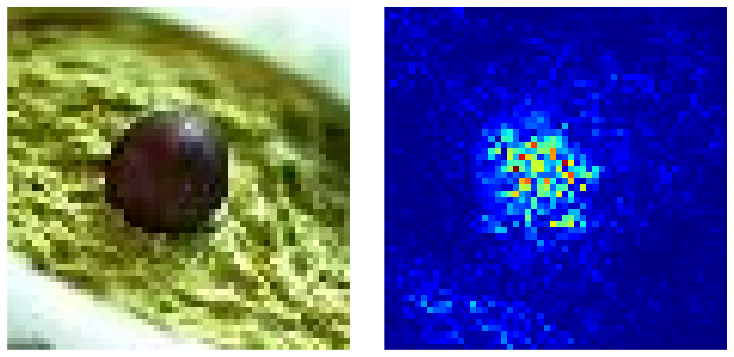

Actual label: guacamole
Top 5 predictions:
['acorn', 'snail', 'pomegranate', 'ladybug', 'slug']




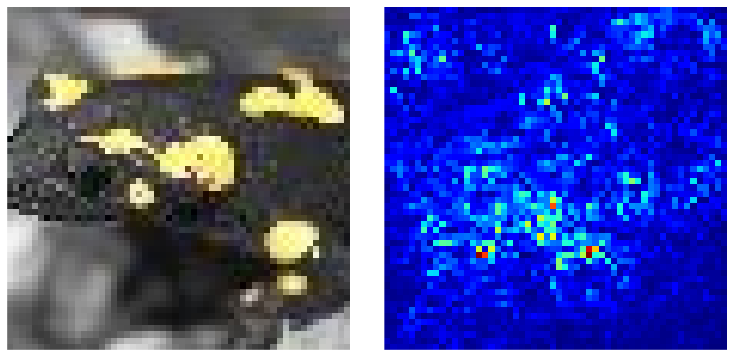

Actual label: European fire salamander
Top 5 predictions:
['European fire salamander', 'chain', 'tailed frog', 'centipede', 'scorpion']




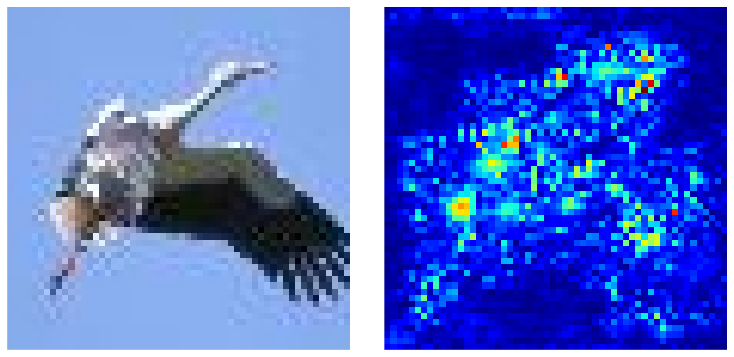

Actual label: black stork
Top 5 predictions:
['black stork', 'albatross', 'goose', 'crane', 'pole']




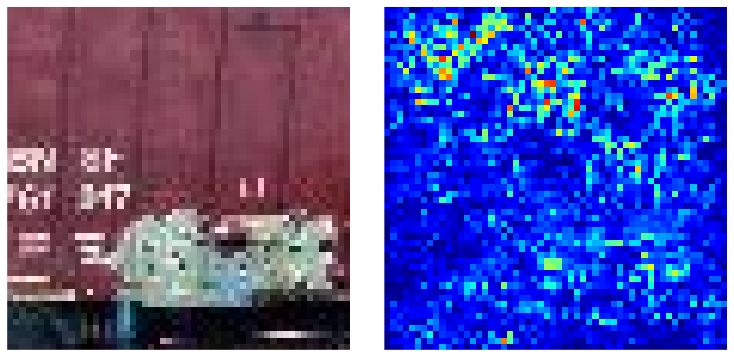

Actual label: freight car
Top 5 predictions:
['freight car', 'moving van', 'desk', 'police van', 'dining table']




In [8]:
N = 10  # number of validation examples to view
filenames_labels = load_filenames_labels('val')
pick_N = random.sample(filenames_labels, N)
imgs = np.zeros((N, 64, 64, 3), dtype=np.uint8)
labels = []
for i, filename_label in enumerate(pick_N):
    imgs[i, :, :, :] = scipy.ndimage.imread(filename_label[0], mode='RGB')
    labels.append(class_description[int(filename_label[1])])
imgs = imgs[:, 4:60, 4:60, :]  # take center crop of images
config = TrainConfig()
top_5, sal_imgs = predict(imgs, config)
top_5 = top_5[1]  # 2nd element of list are class predictions
sal_imgs = sal_imgs[0]  # 1st element of list are saliency maps
# root-sum-square RGB channels of generated saliency heat map
sal_imgs = np.sqrt(np.sum(np.square(sal_imgs), axis=3))

for idx, filename in enumerate(pick_N):
    plt.subplot(121)
    plt.imshow(imgs[idx, :, :, :], interpolation='none')
    # next 5 lines get rid of all white space when saving .png
    plt.gca().set_axis_off()
    plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
                hspace = 0, wspace = 2)
    plt.margins(0,0)
    plt.gca().xaxis.set_major_locator(plt.NullLocator())
    plt.gca().yaxis.set_major_locator(plt.NullLocator())
    plt.subplot(122)
    plt.imshow(sal_imgs[idx, :, :], interpolation='none')
    # next 5 lines get rid of all white space when saving .png
    plt.gca().set_axis_off()
    plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
                hspace = 0, wspace = 0.1)
    plt.margins(0,0)
    plt.gca().xaxis.set_major_locator(plt.NullLocator())
    plt.gca().yaxis.set_major_locator(plt.NullLocator())
    plt.savefig('plots/pred_sal'+str(idx)+'.png', bbox_inches='tight',
                pad_inches=0.0, dpi=64)
    plt.show()
    print('Actual label: ' + labels[idx])
    print('Top 5 predictions:')
    preds = map(lambda x: class_description[x], top_5[idx])
    print([x for x in preds])
    print('\n')